In [1]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("diabetes.csv")
print(data.shape)
data.tail()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [6]:
X = data.iloc[:,:-1] # Independent variables
y = data['Outcome'] # Dependent Variables

# EDA

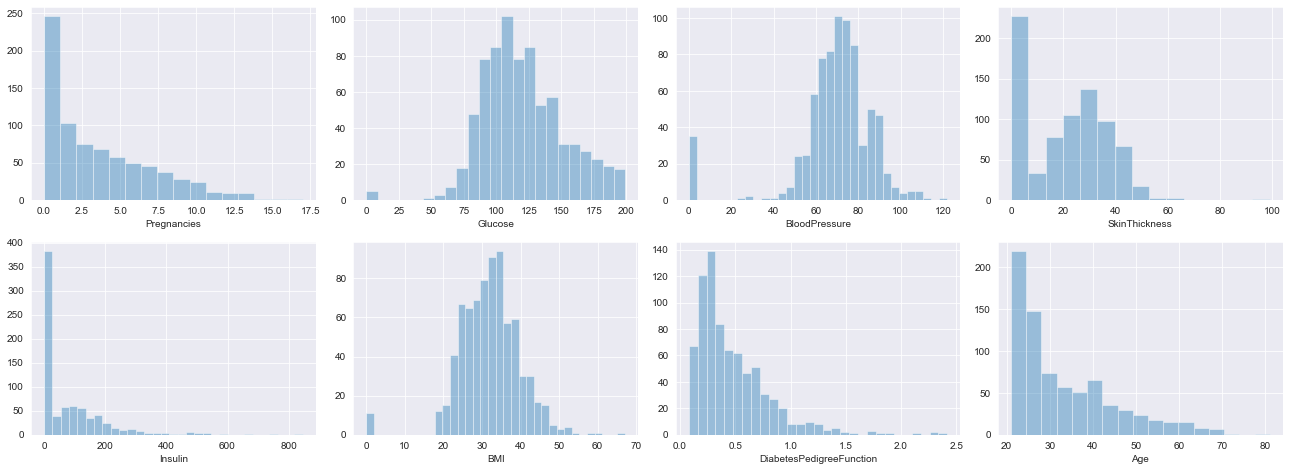

In [7]:
fig = plt.figure(figsize=(18,16))
for index,col in enumerate(X):
    plt.subplot(5,4,index+1)
    sns.distplot(X.loc[:,col],kde= False)
fig.tight_layout(pad=1.0)

# Removing outliers from the Independent variables

In [8]:
data = data.drop(data[data['Pregnancies']>11].index)
data = data.drop(data[data['Glucose']<30].index)
data = data.drop(data[data['BloodPressure']>110].index)
data = data.drop(data[data['BloodPressure']<20].index)
data = data.drop(data[data['SkinThickness']>80].index)
data = data.drop(data[data['BMI']>55].index)
data = data.drop(data[data['BMI']<10].index)
data = data.drop(data[data['DiabetesPedigreeFunction']>1.6].index)
data = data.drop(data[data['Insulin']>400].index)
data = data.drop(data[data['Age']>80].index)

<AxesSubplot:>

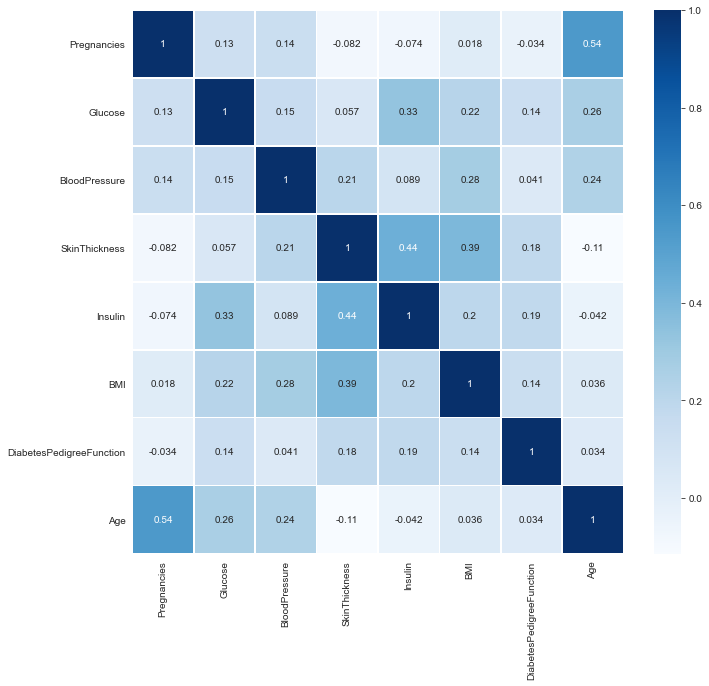

In [9]:
plt.figure(figsize=(11,10))
correlation = X.corr()
sns.heatmap(correlation,linewidth = 0.7,cmap = 'Blues',annot = True)

In [10]:
X = X.loc[data.index]
y = y.loc[data.index]

# Data Scaling

In [11]:
from sklearn.preprocessing import RobustScaler
cols = X.columns
transformer = RobustScaler().fit(X[cols])
X[cols] = transformer.transform(X[cols])

# Data Modeling

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.25,random_state = 100)

In [13]:
from sklearn.metrics import log_loss,accuracy_score,confusion_matrix,f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
xgb = XGBClassifier(booster ='gbtree', objective = 'binary:logistic')

C:\Users\imanursar\AppData\Roaming\Python\Python37\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
from sklearn.model_selection import GridSearchCV
param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

xgb_tuning = GridSearchCV(estimator = xgb, param_grid = param_lst,
                        scoring = 'accuracy',
                        cv = 5, n_jobs=5)
       
xgb_search = xgb_tuning.fit(X_train,y_train,
            early_stopping_rounds=5,
            eval_set=[(X_val,y_val)],
            verbose = False)

##hyperparameter tuning

best_param = xgb_search.best_params_
xgb = XGBClassifier(**best_param)
print(best_param)

{'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1}


In [15]:
y_pred = xgb_search.predict(X_val)
score0 = accuracy_score(y_pred,y_val)
#print(round(score0*100,4))
print('Score: {}%'.format(round(score0*100,4)))

Score: 82.1429%
